# Метрики Sam 2 : Matting

## Импорты

In [26]:
import torch
from torch import nn, Tensor
import torchvision
import os
import tarfile
import shutil
import sys
from PIL import Image
from typing import List
import torch.nn.functional as F
from torchvision import transforms as T
import logging
import numpy as np
import gc
import matplotlib.pyplot as plt
from google.colab import drive
from contextlib import redirect_stdout, redirect_stderr
from io import StringIO

In [27]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Подготовка изображений

In [ ]:
# Путь к архиву
archive_path = '/content/drive/MyDrive/Matting Project/VideoMatte240K_JPEG_SD.tar'

# Папка, куда мы разархивируем данные
extract_path = '/content/VideoMatte240K'

# Разархивируем файл
with tarfile.open(archive_path, "r") as tar:
    tar.extractall(path=extract_path)

print(f"Архив разархивирован в {extract_path}")

Архив разархивирован в /content/VideoMatte240K


Так как в test папке нашего датасета только 4 видео, то используем видео 200-299 из папки train для расчета метрик, При обучении они не использовались.

In [ ]:
# Путь к папкам fgr и pha
base_path = "/content/VideoMatte240K/VideoMatte240K_JPEG_SD/train"
folders = ["fgr", "pha"]

max_images = 10

for folder in folders:
    folder_path = os.path.join(base_path, folder)

    # Сортируем папки по имени
    subfolders = sorted(os.listdir(folder_path))

    for i, subfolder in enumerate(subfolders):
        subfolder_path = os.path.join(folder_path, subfolder)
        if 200 <= i < 300:
            images = sorted(os.listdir(subfolder_path))
            for img_idx, img_name in enumerate(images):
                img_path = os.path.join(subfolder_path, img_name)
                if img_idx >= max_images:
                    os.remove(img_path)
        else:
            # Удаляем оставшиеся папки
            shutil.rmtree(subfolder_path)

print("Обработка завершена.")


Обработка завершена.


In [ ]:
mid_dir = os.path.join(extract_path, 'VideoMatte240K_JPEG_SD')
# Папка test после разархивирования
test_dir = os.path.join(mid_dir, 'train')

# Папки fgr и pha
fgr_dir_test = os.path.join(test_dir, 'fgr')
pha_dir_test = os.path.join(test_dir, 'pha')

Добавляем рандомные фоновые изображения

In [ ]:
import random

def add_backgrounds(base_path):
  # Пути к основным папкам
  fgr_path = os.path.join(base_path, "fgr")
  pha_path = os.path.join(base_path, "pha")
  backgrounds_path = "/content/drive/My Drive/Matting Project/Backgrounds"

  # Папка для сохранения композитных изображений
  output_path = os.path.join(base_path, "images")
  os.makedirs(output_path, exist_ok=True)

  # Получаем список папок (видео) в fgr и pha
  fgr_videos = sorted(os.listdir(fgr_path))
  pha_videos = sorted(os.listdir(pha_path))

  # Проверяем, что количество папок в fgr и pha совпадает
  assert len(fgr_videos) == len(pha_videos), "Количество видео-папок в fgr и pha должно совпадать!"

  # Функция для создания композитного изображения
  def create_composite(fgr, pha, background):
      """
      Смешивает передний план с альфа-каналом и фоновое изображение.
      """
      # Преобразуем изображения в массивы
      fgr = np.array(fgr) / 255.0  # Нормализуем от 0 до 1
      pha = np.array(pha) / 255.0  # Нормализуем от 0 до 1
      background = np.array(background) / 255.0  # Нормализуем от 0 до 1

      # Изменяем размер background до размера fgr/pha
      background = np.array(Image.fromarray((background * 255).astype(np.uint8)).resize((fgr.shape[1], fgr.shape[0]))) / 255.0

      # Композиция: alpha * foreground + (1 - alpha) * background
      composite = (pha[..., None] * fgr) + ((1 - pha[..., None]) * background)
      return (composite * 255).astype(np.uint8)  # Возвращаем в диапазон [0, 255]

  # Проходим по всем папкам (видео)
  for fgr_video, pha_video in zip(fgr_videos, pha_videos):
      # Путь к текущим папкам с кадрами
      fgr_video_path = os.path.join(fgr_path, fgr_video)
      pha_video_path = os.path.join(pha_path, pha_video)

      # Проверяем, что это действительно папки
      if not os.path.isdir(fgr_video_path) or not os.path.isdir(pha_video_path):
          continue

      # Список кадров в текущих папках
      fgr_frames = sorted(os.listdir(fgr_video_path))
      pha_frames = sorted(os.listdir(pha_video_path))

      # Проверяем, что количество кадров совпадает
      assert len(fgr_frames) == len(pha_frames), f"Количество кадров в {fgr_video} и {pha_video} должно совпадать!"

      # Выбираем один случайный фон для текущего видео
      background_file = random.choice(os.listdir(backgrounds_path))
      background_image = Image.open(os.path.join(backgrounds_path, background_file)).convert("RGB")

      # Папка для сохранения композитных изображений для текущего видео
      output_video_path = os.path.join(output_path, fgr_video)
      os.makedirs(output_video_path, exist_ok=True)

      # Создаём композиции для всех кадров текущего видео
      for fgr_frame, pha_frame in zip(fgr_frames, pha_frames):
          # Загружаем передний план и альфа-канал
          fgr_image = Image.open(os.path.join(fgr_video_path, fgr_frame)).convert("RGB")
          pha_image = Image.open(os.path.join(pha_video_path, pha_frame)).convert("L")  # Альфа-канал в градациях серого

          # Создаём композицию
          composite_image = create_composite(fgr_image, pha_image, background_image)

          # Сохраняем результат
          output_file = os.path.join(output_video_path, fgr_frame)
          Image.fromarray(composite_image).save(output_file)

  print(f"Готово! Композитные изображения сохранены в папку {output_path}.")

In [ ]:
add_backgrounds("/content/VideoMatte240K/VideoMatte240K_JPEG_SD/train")

Готово! Композитные изображения сохранены в папку /content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/images.


In [ ]:
image_dir_test = os.path.join(test_dir, "images")

In [35]:
video_ids = sorted(os.listdir(image_dir_test))

In [ ]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True


# Загрузка модели

In [ ]:
sys.path.append('/content/drive/My Drive/Matting Project/sam2')

In [ ]:
!{sys.executable} -m pip install hydra-core > /dev/null

In [ ]:
!{sys.executable} -m pip install iopath > /dev/null

In [ ]:
from hydra import initialize_config_dir
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate

In [ ]:
config_dir = "/content/drive/My Drive/Matting Project/configs"
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize_config_dir(config_dir=config_dir, version_base="1.1")

hydra.initialize_config_dir()

In [ ]:
from sam2.build_sam_matting import build_sam2_video_predictor_matting
from sam2.build_sam import build_sam2_video_predictor

Используем Hydra и наши новые чекпойнты и новый класс создания модели build_sam2_video_predictor_matting.

Создаем матирующую модель с новым lora-адаптером и исходную sam2 модель для сравнения.

In [ ]:
checkpoint_base = "/content/drive/My Drive/Matting Project/checkpoints/sam2.1_hiera_large.pt"
checkpoint = "/content/drive/My Drive/Matting Project/checkpoints/sam2.1_hiera_large_matting.pt"
model_cfg = "sam2.1_hiera_l_predictor.yaml"
predictor = build_sam2_video_predictor_matting(model_cfg, checkpoint)
predictor_base = build_sam2_video_predictor(model_cfg, checkpoint_base)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Расчет метрик

Функция для семплирования точек нажатия по центру необходимой фигуры.

In [93]:
def get_random_central_point_with_value_one(pha_image):
    # Преобразуем изображение в массив numpy
    image_array = np.array(pha_image)

    # Находим индексы всех точек, где значение равно 255
    points = np.argwhere(image_array == 255)

    # Проверяем, есть ли такие точки
    if len(points) == 0:
        raise ValueError("В изображении нет точек со значением 255.")

    # Находим центр изображения
    center_y, center_x = image_array.shape[0] / 2, image_array.shape[1] / 2

    # Вычисляем расстояния от каждой точки до центра
    distances = np.sqrt((points[:, 0] - center_y) ** 2 + (points[:, 1] - center_x) ** 2)

    # Сортируем точки по расстоянию до центра
    sorted_indices = np.argsort(distances)
    central_points = points[sorted_indices]

    # Берем 5% самых центральных точек
    num_central_points = max(1, len(central_points) // 20)
    selected_points = central_points[:num_central_points]

    # Выбираем случайную точку из 50% центральных
    random_point = selected_points[np.random.choice(selected_points.shape[0])]

    # Меняем порядок координат с (y, x) на (x, y) и возвращаем в формате [[x, y]]
    return np.array([[random_point[1], random_point[0]]])

Функции для подготовки данных и расчета метрик.

In [94]:
def prepareDate(video_id):
  image_video_dir = os.path.join(image_dir_test, video_id)
  pha_video_dir = os.path.join(pha_dir_test, video_id)

  pha_frames = sorted(os.listdir(pha_video_dir))
  pha_path = os.path.join(pha_video_dir, pha_frames[0])
  pha_image = Image.open(pha_path).convert("L")
  input_point = get_random_central_point_with_value_one(pha_image)

  return image_video_dir, input_point, pha_video_dir

In [95]:
def run_metric(metric, input, pha_frames, pha_video_dir):
        torch.cuda.empty_cache()
        ret = 0
        for i in range(len(input)):
          input_t = torch.sigmoid(input[i][1][0].clone().cpu())
          pha_path = os.path.join(pha_video_dir, pha_frames[i])
          target = Image.open(pha_path).convert("L")
          target_t = T.ToTensor()(target)[0].clone().cpu()
          mask = torch.ones_like(target_t).clone().cpu()

          if metric == 'sad':
              ret += BatchSAD(input_t, target_t, mask)
          elif metric == 'mse':
              ret += BatchMSE(input_t, target_t, mask)
          elif metric == 'mad':
              ret += BatchMAD(input_t, target_t, mask)
          else:
              raise NotImplementedError
        return (ret / len(input)).item()

def BatchSAD(pred, target, mask):
    error_map = (pred - target).abs()
    batch_loss = (error_map * mask).sum()
    batch_loss = batch_loss / 1000
    return batch_loss.data.cpu().numpy()

def BatchMSE(pred, target, mask):
    error_map = (pred-target)
    batch_loss = (error_map.pow(2) * mask).sum()
    batch_loss = batch_loss / (mask.sum() + 1.)
    return batch_loss.data.cpu().numpy() * 1000

def BatchMAD(pred, target, mask):
    error_map = (pred - target).abs()
    batch_loss = (error_map * mask).sum()
    batch_loss = batch_loss / (mask.sum() + 1.)
    return batch_loss.data.cpu().numpy() * 1000

In [96]:
def processVideo(video_id, predictor):
  with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
      image_video_dir, input_point, pha_video_dir = prepareDate(video_id)
      state =predictor.init_state(image_video_dir)

      # add new prompts and instantly get the output on the same frame
      frame_idx, object_ids, masks = predictor.add_new_points_or_box(inference_state=state,
      frame_idx=0,
      obj_id=1,
      points=input_point,
      labels=np.array([1]))

      # propagate the prompts to get masklets throughout the video
      video_masks = {}  # video_segments contains the per-frame segmentation results
      for frame_idx, object_ids, masks in predictor.propagate_in_video(state):
          video_masks[frame_idx] = {
          obj_id: masks[i]
          for i, obj_id in enumerate(object_ids)
      }

      pha_frames = sorted(os.listdir(pha_video_dir))

  return  video_masks, pha_frames, pha_video_dir

Прогоняем модели по всем папкам с видео и расчитываем метрики.

In [36]:
sad_metric = []
mad_metric = []
mse_metric = []
sad_metric_base = []
mad_metric_base = []
mse_metric_base = []
for video_id in video_ids:
  with redirect_stdout(StringIO()), redirect_stderr(StringIO()):
    masks, pha_frames, pha_video_dir = processVideo(video_id, predictor)
    masks_base_net, pha_frames, pha_video_dir = processVideo(video_id, predictor_base)
    sad_metric.append(run_metric('sad', masks, pha_frames, pha_video_dir))
    sad_metric_base.append(run_metric('sad', masks_base_net, pha_frames, pha_video_dir))
    mad_metric.append(run_metric('mad', masks, pha_frames, pha_video_dir))
    mad_metric_base.append(run_metric('mad', masks_base_net, pha_frames, pha_video_dir))
    mse_metric.append(run_metric('mse', masks, pha_frames, pha_video_dir))
    mse_metric_base.append(run_metric('mse', masks_base_net, pha_frames, pha_video_dir))
    torch.cuda.empty_cache()
    gc.collect()

print(f'SAD: {np.mean(sad_metric)}')
print(f'MAD: {np.mean(mad_metric)}')
print(f'MSE: {np.mean(mse_metric)}')

print(f'SAD_Sam2: {np.mean(sad_metric_base)}')
print(f'MAD_Sam2: {np.mean(mad_metric_base)}')
print(f'MSE_Sam2: {np.mean(mse_metric_base)}')

SAD: 5.639358961760998
MAD: 17.11857883655466
MSE: 15.173368273564847
SAD_Sam2: 31.777083465397354
MAD_Sam2: 96.14875594817568
MSE_Sam2: 92.7790659313323


In [101]:
sad_metric[27]

54.290007781982425

# Визуализация

Добавляем функции для предсказания по одному видео и выводу изображений

In [80]:
def predict(video_id, predictor, predictor_base):
  masks, pha_frames, pha_video_dir = processVideo(video_id, predictor)
  masks_base_net, pha_frames, pha_video_dir = processVideo(video_id, predictor_base)
  image_video_dir = os.path.join(image_dir_test, video_id)
  image_frames = sorted(os.listdir(image_video_dir))
  image_path = os.path.join(image_video_dir, image_frames[0])
  image = Image.open(image_path).convert("RGB")
  pha_path = os.path.join(pha_video_dir, pha_frames[0])
  pha_image = Image.open(pha_path).convert("L")
  pred = torch.sigmoid(masks[0][1][0].clone().cpu())
  pred_base = torch.sigmoid(masks_base_net[0][1][0].clone().cpu())

  return image, pha_image, pred, pred_base

In [86]:
def show_original(image, pha_image):
  fig, axes = plt.subplots(1, 2, figsize=(15, 7))

  axes[0].imshow(pha_image)
  axes[0].set_title("Маска gt")
  axes[0].axis('on')  # Показать оси

  axes[1].imshow(image)
  axes[1].set_title("Исходное изображение")
  axes[1].axis('on')

  plt.tight_layout()
  plt.show()

In [97]:
def show_masks(pred, pred_base):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  axes[0].imshow(pred)
  axes[0].axis('off')  # Скрыть оси
  axes[0].set_title("Matting")

  axes[1].imshow(pred_base)
  axes[1].axis('off')  # Скрыть оси
  axes[1].set_title("Sam2 Original")

  for ax, im in zip(axes, [pred, pred_base]):
      plt.colorbar(ax.imshow(im), ax=ax)

  plt.tight_layout()
  plt.show()

In [98]:
video_id = '0208'
with redirect_stdout(StringIO()), redirect_stderr(StringIO()):
  image, pha_image, pred, pred_base = predict(video_id, predictor, predictor_base)

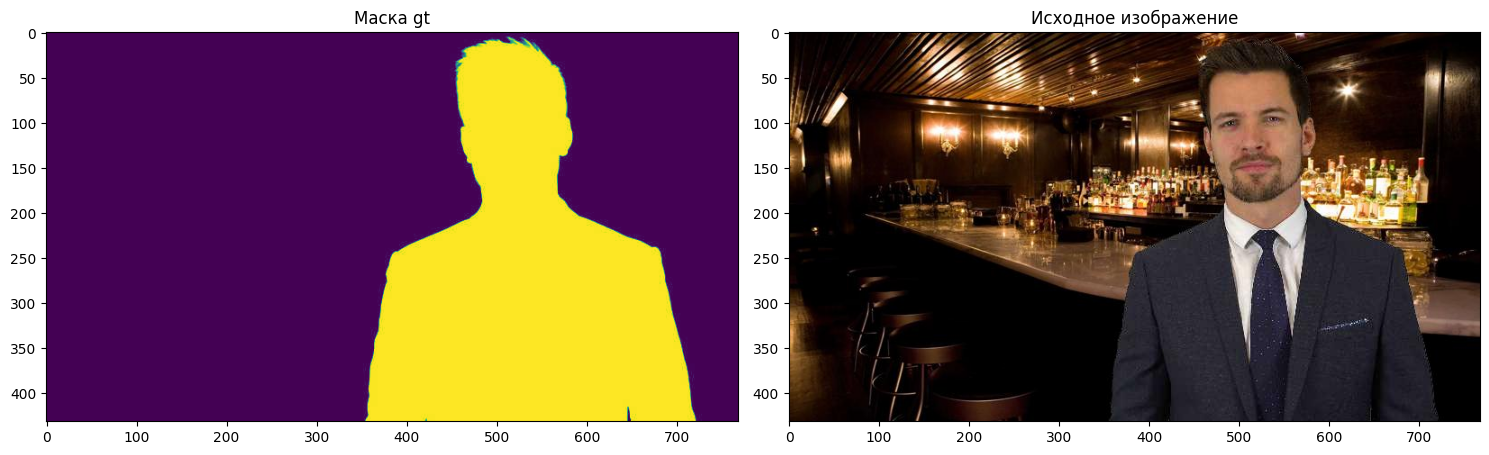

In [99]:
show_original(image, pha_image)

Мы видим, что в отличие от оригинального sam2 матирующая сеть делает сплошным центр фигуры, чтобы маску можно было использовать как альфа-маску. Края стали более аккуратными, матирующая сеть попыталась немного поаккуратнее вырезать волосы.

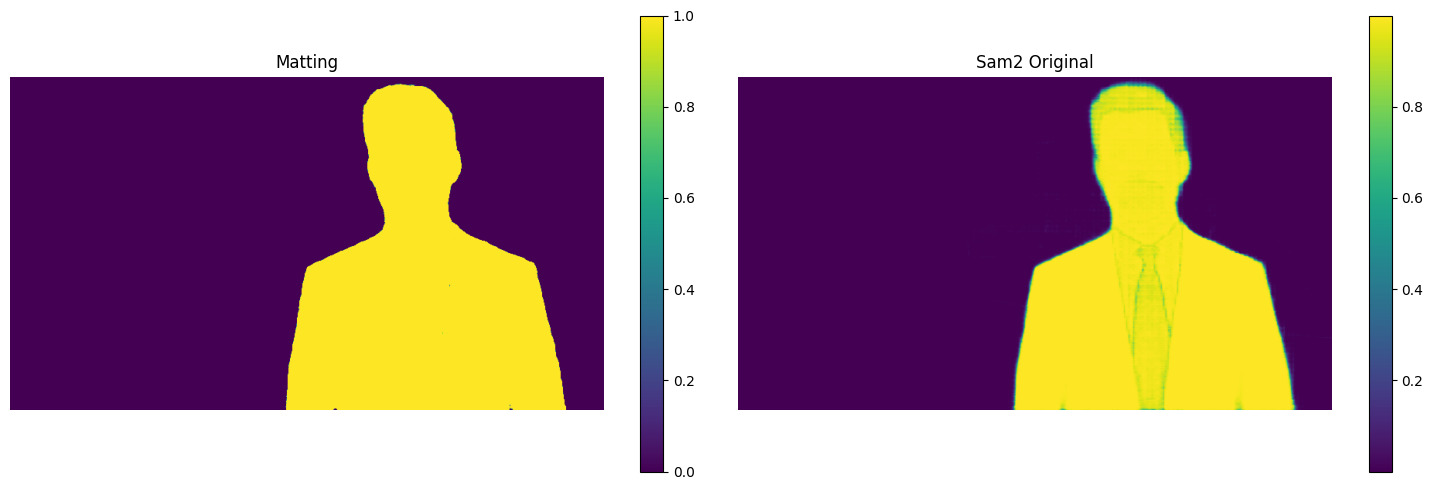

In [100]:
show_masks(pred, pred_base)

In [104]:
video_id = '0225'
with redirect_stdout(StringIO()), redirect_stderr(StringIO()):
  image, pha_image, pred, pred_base = predict(video_id, predictor, predictor_base)

В датасете случаются ошибки. Напрмер, здесь как gt помечены два человека на видео, что неправильно согласно логике работы нашей сети. Формально ошибка в обоих случаях здесь будет довольно большой.

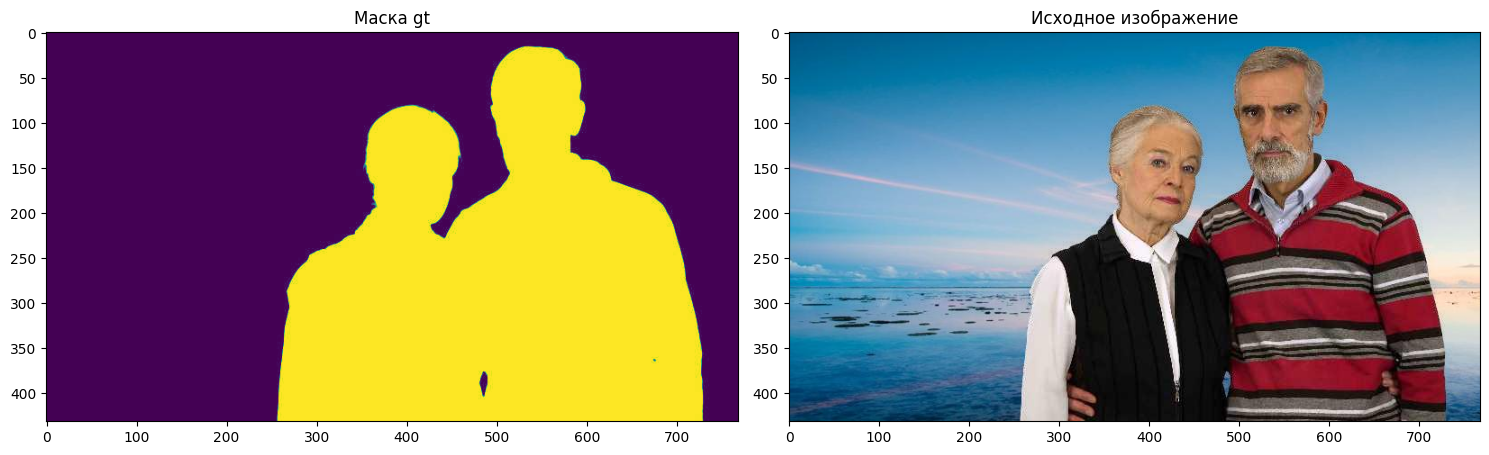

In [105]:
show_original(image, pha_image)

Однако сеть справляется. Мы видим, что матирующая сеть аккуратнее вырезает пальцы мужчины.

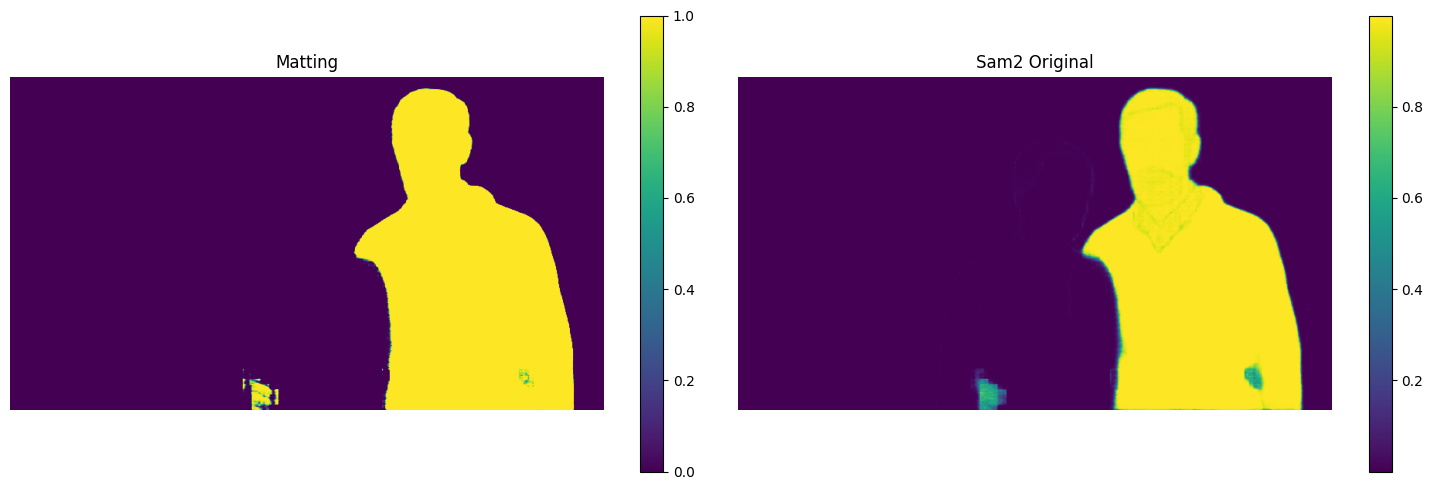

In [84]:
show_masks(pred, pred_base)

In [109]:
video_id = '0250'
with redirect_stdout(StringIO()), redirect_stderr(StringIO()):
  image, pha_image, pred, pred_base = predict(video_id, predictor, predictor_base)

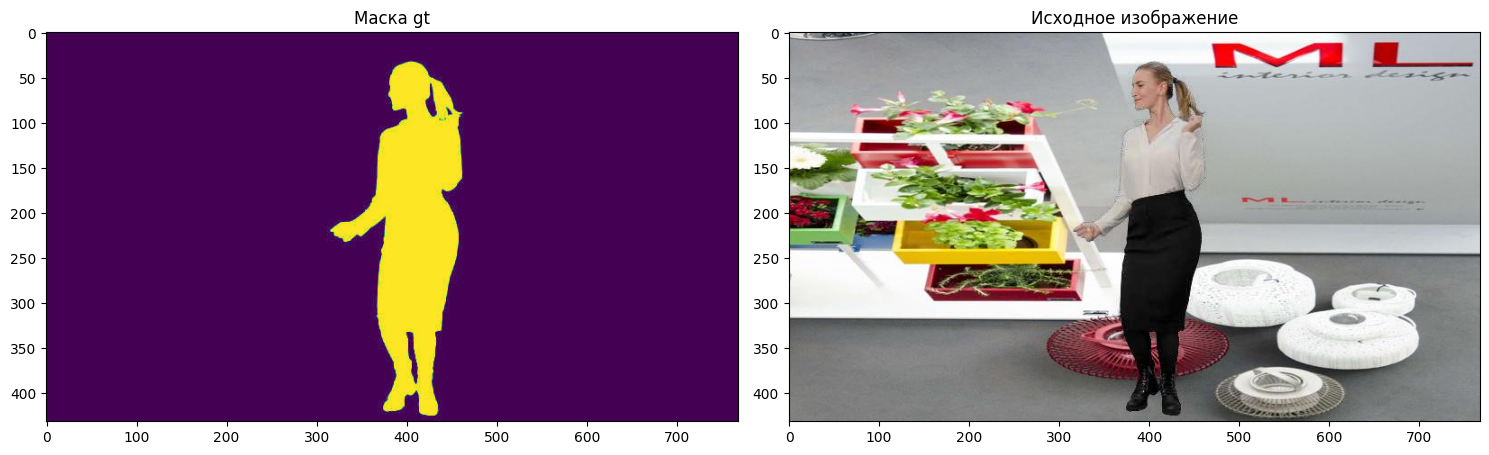

In [110]:
show_original(image, pha_image)

Здесь также видим, что матирующая сеть лучше вырезает волосы, руки и туфли женщины.

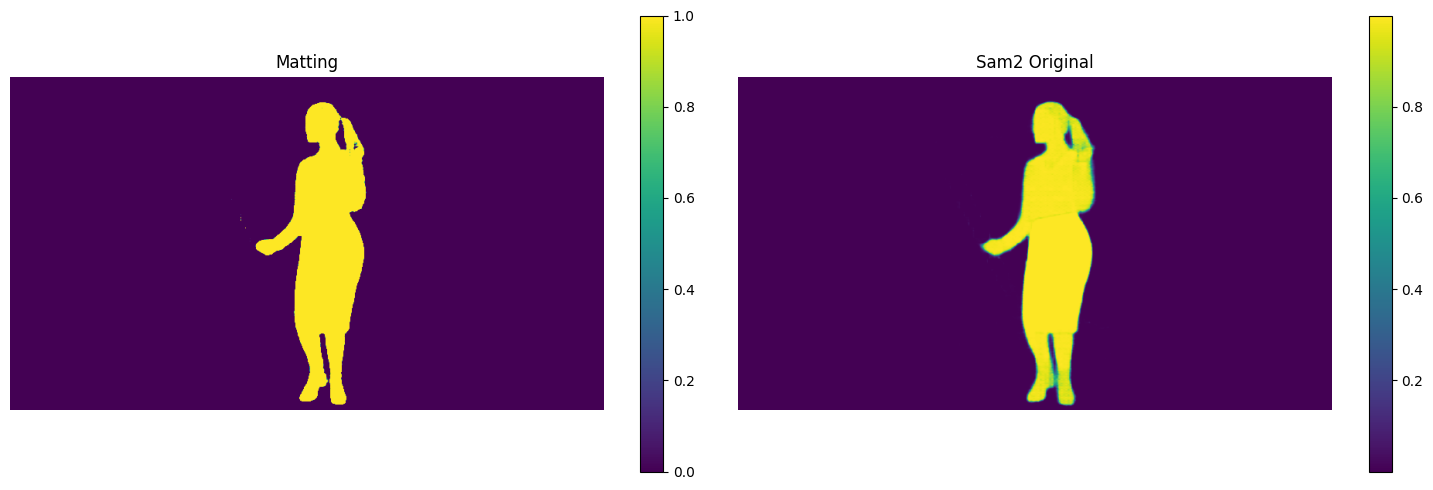

In [111]:
show_masks(pred, pred_base)